<h1 style="text-align: center;">App Profiles Data Analysis</h1>

<h2 style="text-align: center;">Proposing A Successful App Profile from Google PlayStore Dataset</h2>

## Introduction

This is a data analyst project idea borrowed directly from [dataquest.io](https://www.dataquest.io/projects/guided-project-a-profitable-app-profiles-for-the-app-store-and-google-play-markets-2/). Modifications have been made to the original project instructions.

The aim of the project here is to analyse a Google Playstore apps dataset and propose an app profile to a fictional client. The client plans to develop a free app that will only generate revenue through ads, and therefore needs information on a profile that will ensure popularity and attract the most users. 

The profile to be proposed has 2 constraints:

- the app must be free to use (i.e. non-paying; revenue can only be made from ads).
- the app must be for English language-speakers.

The dataset is a CSV file that can be downloaded directly from this [link](https://dq-content.s3.amazonaws.com/350/googleplaystore.csv).

Documentation for the dataset can also be found [here](https://www.kaggle.com/datasets/lava18/google-play-store-apps).

Further details about the dataset and project idea can be found in the Acknowledgements section below.

## Data Import and Preliminary Inspection

### Imports

First, we import the Python libraries necessary for our data analysis.

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Then we import the Play Store dataset.

We import and store it as a panda dataframe.

In [2]:
# Data import
playstore = pd.read_csv('googleplaystore.csv')

### Inspect imported datasets

Use pandas dataframe methods like `head`, `info`, `describe` to inspect the data

In [3]:
# Info on dataset shape (rows/columns) and data types
print(playstore.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10841 entries, 0 to 10840
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             10841 non-null  object 
 1   Category        10841 non-null  object 
 2   Rating          9367 non-null   float64
 3   Reviews         10841 non-null  object 
 4   Size            10841 non-null  object 
 5   Installs        10841 non-null  object 
 6   Type            10840 non-null  object 
 7   Price           10841 non-null  object 
 8   Content Rating  10840 non-null  object 
 9   Genres          10841 non-null  object 
 10  Last Updated    10841 non-null  object 
 11  Current Ver     10833 non-null  object 
 12  Android Ver     10838 non-null  object 
dtypes: float64(1), object(12)
memory usage: 1.1+ MB
None


In [4]:
# Inspect for columns with readily analyzable data
playstore.describe()

,Rating
count,9367.000000
mean,4.193338
std,0.537431
min,1.000000
25%,4.000000
50%,4.300000
75%,4.500000
max,19.000000


In [5]:
# Check total null entries per column
playstore.isna().sum()

App                  0
Category             0
Rating            1474
Reviews              0
Size                 0
Installs             0
Type                 1
Price                0
Content Rating       1
Genres               0
Last Updated         0
Current Ver          8
Android Ver          3
dtype: int64

In [6]:
# Preview of first 3 rows
playstore.head(3)

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up


### Preliminary observations from inspecting the raw dataset:
- **Dataset Size**: there are 10,841 apps in the dataset, with 13  columns. Recall that we only interested in apps that are free and for English-speaking users.
  
- **Data Type Formats**: Only the 'Rating' column is a non-string format (float64); the rest are strings (even the ones that seemly contain numbers). Some of these columns (like 'Installs', 'Price', 'Reviews', and 'Last Updated') contain data that we will possibly perform analysis on, will require type conversions.

- **Null Data**: The 'Rating' has column has the highest number of `NULL` entries (1,474); other columns have between 0 - 8, which is good.

- **Erroneous Data**: Note also the max rating value of 19.0 - very unusual and most likely erroneous data.

With these preliminary observations noted, let's proceed with cleaning the data.

## Data Cleaning

### Steps

The following cleaning steps will be carried out for the data set:

1. Data type conversions
2. Clean 'Rating' column
3. Filter out remaining `NULL` entries
4. Filter out duplicates
5. Filter out non-English apps
6. Filter our apps that are not free
7. Check for blanks and filter out erroneous data
8. Lastly, we reset index for sequential numbering


### Columns datatype conversions


#### 'Installs' column

In [7]:
## Pre-inspected with bar plot of `value_counts` (`dropna` set to False to include nulls)
## Column with 'Free' spotted - locate row with
## playstore[playstore.Installs == 'Free']
## Incorrect datascrape for this row; drop the row

# Filter out the 
mask = playstore.Installs == 'Free'
playstore = playstore[~mask]

# 'Installs' column object to int64 dtype
playstore['Installs'] = playstore['Installs'].str.replace('+', '').str.replace(',','').astype('int64')

#### 'Price' column

In [8]:
# Pre-inspected with plot of `value_counts` (`dropna` set to False to include nulls)

# 'Price' column object to float64 dtype
playstore['Price'] = playstore['Price'].str.replace('$', '').astype('float64')

#### 'Size' column

In [9]:
## Pre-inspected with plot of `value_counts` (`dropna` set to False to include nulls)
## We learn that there are 2 multipliers - M and k; rest columns have text "Varies with device"
## We will create a Size-in-kbytes column with corresponding the values

# Extract size multiplier (i.e.'M' or 'k') to integer values
extract = playstore.Size.str[-1]
mmap = {'M':1000, 'k':1}
SizeMultiplier = np.array([mmap[x] if x in mmap.keys() else np.nan for x in extract])

# Extract the 'Size' integer portion and broadcast to new column 'SizeBytes' float dtype column
playstore['SizeKBytes'] = pd.to_numeric(playstore.Size.str[:-1], errors='coerce') * SizeMultiplier

#### 'Reviews' column

In [10]:
# Convert 'Reviews' to numeric type
playstore['Reviews'] = pd.to_numeric(playstore['Reviews'])

### Clean the 'Rating' column

We had noted a row with an unusually high rating 19.0; this is probably an error but we don't know for sure. So best option is eliminate the row.

We will use a boolean mask to filter out the row. Then we inspect the resultant 'Rating' column with a plot of its values to confirm clean.

In [11]:
# Use a boolean mask to filter out 19.0 rating
mask = playstore['Rating'] == 19.0
playstore = playstore[~mask]

### Remove `NULL` entries

We simply drop all rows containing at least 1 `NaN` or `Null` entry with pandas `dropna` method.

In [12]:
# Drop all rows with `Null` data
playstore = playstore.dropna()

### Remove duplicates

In [13]:
# Check for 'App' duplicates
playstore[playstore['App'].duplicated()].shape

(700, 14)

There are 700 app duplicates. 

We do a bit of inspection by sorting the dataset by app name; it shows that some of the duplicates have varying number of reviews. 

In [14]:
# Sort duplicates by 'App' and inspect the last 4th and 3rd rows
playstore[playstore['App'].duplicated()].sort_values('App').iloc[-4:-2]

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver,SizeKBytes
3014,"theScore: Live Sports Scores, News, Stats & Vi...",SPORTS,4.4,133825,34M,10000000,Free,0.0,Everyone 10+,Sports,"July 25, 2018",6.17.2,4.4 and up,34000.0
3085,"theScore: Live Sports Scores, News, Stats & Vi...",SPORTS,4.4,133833,34M,10000000,Free,0.0,Everyone 10+,Sports,"July 25, 2018",6.17.2,4.4 and up,34000.0


We will retain the duplicates with the highest reviews (infering that these are the most recent), and drop the rest. 

'Review' column is already in numeric format so we just sort the dataset by 'App' and 'Reviews', then find and filter out duplicates from the sorted dataset.

In [15]:
# Sort the dataset by 'App' ascending and 'Reviews' descending
playstore.sort_values(by=['App','Reviews'],ascending=[True,False])

# Make a mask of the duplicates (from the sorted dataset)
mask = playstore['App'].duplicated()

# Filter out duplicates 
playstore = playstore[~mask]

### Remove non-English apps

For this, we analysis the name column 'App' and remove all rows with non-English text words (i.e. words containing characters that are not used in English text).

A general rule-of-thumb for the ASCII ** is that English text characters have Unicode numeric values 0 - 127. So we can assume that any character with value greater than 127 is a non-English text character.

We apply this rule-of-thumb with a quick function `nenglish` to check for non-English text strings in the app names. The function employs Python's inbuilt `ord()` function which returns the Unicode numeric value of any character.

In [16]:
# nenglish function -> returns true for non-English language strings 
def nenglish(string):
    count = 0
    for char in string:
        if ord(char) > 127: 
            count += 1
            if count > 3: return True
    return False

The code below generates a list of all app names in the dataset and runs the list through the `nenglish` function as a list comprehension. 

The result is a Numpy boolean mask which we then use to extract the non-English apps.

In [17]:
# Run a list of App names through the `nenglish()` function to get a boolean mask of the non-English apps 
non_english_mask = np.array([nenglish(app) for app in playstore['App'].tolist()])

# Apply mask to dataset to get the non-English apps
playstore[non_english_mask].tail(2)

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver,SizeKBytes
10098,Ey Sey Storytime រឿងនិទានតាឥសី,FAMILY,4.7,1327,44M,10000,Free,0.0,Everyone,Education;Education,"May 18, 2017",1.2.2,4.0.3 and up,44000.0
10763,FP Разбитый дисплей,FAMILY,4.5,922,552k,50000,Free,0.0,Everyone,Entertainment,"September 20, 2014",1.1,1.6 and up,552.0


Reverse the non-English apps mask to filter out the non-English apps

In [18]:
# Filter out non_English apps
playstore = playstore[~non_english_mask]

### Remove all paid apps

We first investigate the 'Type' and 'Price' columns with `value-counts` to a bar plot to visualise the prices.

In [19]:
# Check 'Type' value_counts plot --> 2 values: 'Free' and 'Paid'
playstore.Type.value_counts()

# Use boolean mask to filter out 'Paid' apps
mask = playstore['Type'] == 'Paid'
playstore = playstore[~mask]

### Review cleaning results

This marks the end of the data cleaning process.

The last step is to reset the index and export a copy of the cleaned dataset to a CSV file before we proceed to data analysis.

In [20]:
# Reset the index
playstore = playstore.reset_index()
playstore = playstore.drop('index',axis=1)

# Export cleaning results to CSV file
playstore.to_csv('googleplaystore_rev.csv', index=False)

## Data Analysis

Let us recall the aim of the project - to analyse the playstore data and propose an app profile which is most likely to attract the highest number of users.

This means that the app profile should be able to demostrate the following attributes:

- **Popularity** - high downloads, high number of reviews

- **High user engagement** - high review count, top-rated

Additionally, it is also essential that the profile avoid highly competitive categories where it's chances of success will be severely limited by massively established and already successful competitors. This means we must also aim for a **Niche category** that still satisfies the popularity and user engagement requirements.

### Category frequency table

To determine which categories that best satisfy the stated requirements of our app profile, we look at the **app category trends** in our dataset. We extract pivoted data from our original "long-form" dataset into a "wide-form" Category frequency table. This table will contain categorical information about:
- **total number of apps**

- **total and averaged downloads**

- **total and average review counts**

- **average rating**

It is possible that some categories may have a high volume of apps which could in turn affect the total number of downloads and/or reviews that they get, so the computed averages (the total value counts divided by the number of apps in the category) are used to give a more balanced view.

**Notes on the Category frequecy table**:

1. Due to the massive amounts of downloads and reviews in some apps (and because we are dealing with categorical sums), the downloads and number of reviews are reduced to units per million and units per one hundred thousand respectively.
  
2. The dataset does not provide specify downloads figures, rather they are provided as estimates (e.g. 50,000+, 100,000+, etc.). It is therefore possible that two apps, with widely varying downloads such as 501,000 and 997,100, would both be recorded as 500,000+, thereby introducing very misleading approximations into the dataset. We will however work with the dataset as it is, and make our deductions based on it.

The code below takes us through the steps of building the frequency table.

In [21]:
## Build the Category Frequency Table (table0)

# Get the number of apps per category, sorted by category name
table0 = playstore.Category.value_counts().reset_index()
table0.columns = ['Category', 'NumOfApp']
table0 = table0.sort_values(by='Category', ascending=True)

# Get Total and Average Downloads per Category (in millions)
df = (playstore.Installs.groupby(playstore.Category).sum()).reset_index()
df = df.sort_values(by='Category', ascending=True)
table0['TotInstalls'] = df['Installs'].values / 1000000
table0['AvgInstalls'] = round(table0.TotInstalls / table0.NumOfApp, 2)

# Get Total and Average Review counts per Category (in hundred thousands) 
df = playstore.Reviews.groupby(playstore.Category).sum().reset_index()
table0['TotReviews'] = df['Reviews'].values / 100000
table0['AvgReviews'] = round(table0.TotReviews / table0.NumOfApp, 2)

table0.head(3) # View first 3 rows

,Category,NumOfApp,TotInstalls,AvgInstalls,TotReviews,AvgReviews
26,ART_AND_DESIGN,54,99.2111,1.84,10.85041,0.20
23,AUTO_AND_VEHICLES,63,43.7698,0.69,9.92286,0.16
32,BEAUTY,37,13.4162,0.36,1.85749,0.05


### Estimating Popularity & User Engagement

#### Most Downloaded & Reviewed Categories

Since our dataset contains only discrete data, we use a combined bar plot to visualize the most downloaded and reviewed categories.

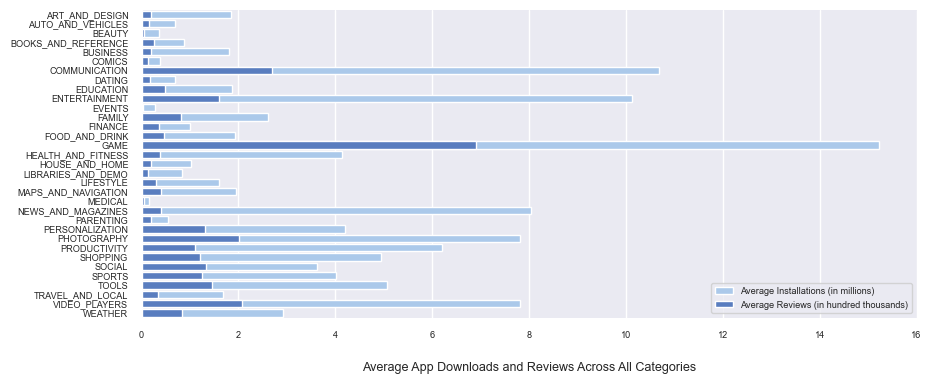

In [22]:
# Set plot theme and initialize figure
sns.set(style='darkgrid',font_scale=0.6)
fig, axs = plt.subplots(figsize=(10,4))

# Plot the Average Downloads
sns.set_color_codes("pastel")
ax1 = sns.barplot(x='AvgInstalls', y='Category', data=table0, label='Average Installations (in millions)', color='b')

# Plot the Average Reviews
sns.set_color_codes("muted")
ax2  = sns.barplot(x='AvgReviews', y='Category', data=table0, label='Average Reviews (in hundred thousands)', color='b')

# Add a legend and informative labels
axs.legend(ncol=1, loc="lower right", frameon=True)
axs.set(xlim=[0,16], ylabel="", xlabel='')
sns.despine(left=True, bottom=True)
plt.title("Average App Downloads and Reviews Across All Categories", fontsize=9, y=-0.2)

plt.show()

From the combined bar chart above, it is evident that out of 33 app categories analysed, the **Game** category is by far the most downloaded and most reviewd app category.

Other high ranking categories (from mere visual review) would include:
- Communication
- Entertainment
- Photography
- Video players.

But we can define specific limits and make quantitatively deductions of categorical popularity.

If we define the most popular categories as those with **more than 6 million average download OR more than 150 thousand average reviews**, we can use these limits to extract and visualise these categories.

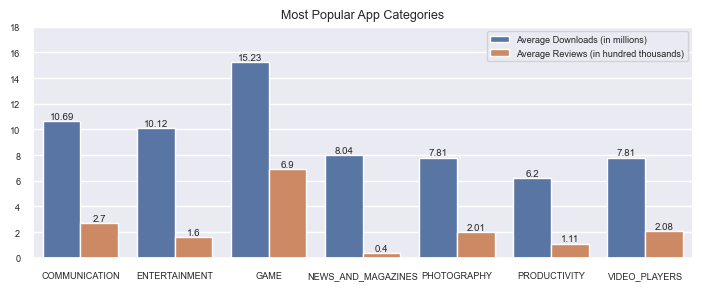

In [23]:
# Extract the category table for most popular app categories
list1 = table0[table0.AvgInstalls > 6].Category.tolist() # Categories with avg. downloads > 6 million
list2 = table0[table0.AvgReviews > 1.5].Category.tolist() # Categories with avg. reviews > 150,000
table1 = table0[table0.Category.isin(list1) | table0.Category.isin(list2)].copy()

# Create temporary long-form dataframe for the bar plot
x , y = 'Average Downloads (in millions)','Average Reviews (in hundred thousands)'
df = table1.rename(columns={'AvgInstalls': x,'AvgReviews': y})
df = df.melt(id_vars=['Category'],value_vars=[x,y]) # Un-pivot the table to long-form

# Bar plot of the most popular categories
sns.set(font_scale=.6)
fig, axs = plt.subplots(figsize=[8.5,3])
axs = sns.barplot(x='Category', y='value', data=df, hue='variable', width=0.8)
axs.set(ylim=[0,18], ylabel='', xlabel='')
axs.legend(ncol=1, loc="upper right", frameon=True)
for i in range(0,len(axs.containers)):
    axs.bar_label(axs.containers[i], fontsize=7)
sns.despine(fig)
plt.title('Most Popular App Categories', fontsize=9)

plt.show()

From the resultant bar plot above, we can definitely confirm that our most popular app categories are:
- Communication
- Entertainment
- Game
- News and Magazines
- Photography
- Productivity
- Video players

#### User Engagement

Next, we will further analyse for user engagement across our selected most popular categories. 

Since we have already established that these categories have the highest review counts, we will instead analyse for **positive feedback** as measure of user engagement. 

We do this by making box plots of the Rating column from the "long-form" cleaned dataset.

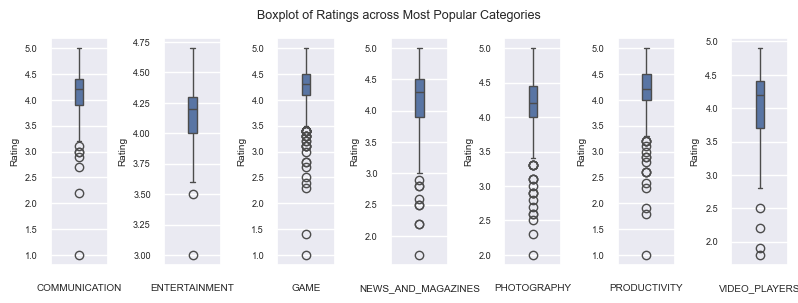

In [24]:
# Box plot of Ratings across Categories
sns.set(font_scale=0.6)
cat = table1.Category.tolist() # List of the most popular categories
fig, axs = plt.subplots(1, len(cat), figsize=[8,3]) # Make a sub-plot for each category
i = 0
for a in axs:
    a = sns.boxplot(y=playstore.Rating[(playstore.Category==cat[i])], width=0.15, ax=axs[i])
    a.set(xlabel=cat[i], ylabel='Rating')
    i += 1

plt.suptitle('Boxplot of Ratings across Most Popular Categories', fontsize=9)
plt.tight_layout()
plt.show()

The box plots show that the selected categories all have overwhelmingly positive ratings, with a cumulative mean above 4.0.

It can also be observed that the **Entertainment** category has the fewest outliers (only 2), and its lowest rated outlier is up to 3.0, while all other categories have outliers as low as 1.5.

But we still need to establish a ranking which will aid our final app profile decision among these most popular apps. 

#### Popularity Index

To establish the popularity rank, we define a **popularity index as the root-sum-square (RSS) value of the average downloads and review counts.**

In [25]:
# Compute the Popularity Index (P-Index)
table1['Pindex'] = round((table1.AvgInstalls**2 + table1.AvgReviews**2)**0.5, 1)
table1['Pindex_text'] = table1.Category + " (" + table1.Pindex.astype(str) + ")" # Text column for plotting

Now we can select and visualize the top-5 popularity indices as a scatter plot of average downloads vs average reviews:

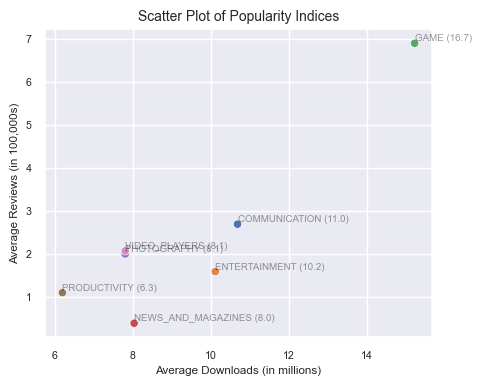

In [26]:
# Scatter plot of the P-indices
sns.set(font_scale=0.7)
fig, axs = plt.subplots(figsize=[5,4])

sns.scatterplot(x='AvgInstalls', y='AvgReviews', hue='Category', data=table1, legend=False)
axs.set(xlabel='Average Downloads (in millions)', ylabel='Average Reviews (in 100,000s)')

# Annotate the points with corresponding P-index value
for i, row in table1.iterrows():  
    axs.text(row['AvgInstalls'], row['AvgReviews'], row["Pindex_text"], 
            fontsize=7, ha='left', va='bottom', color='black', alpha=0.4)

plt.title('Scatter Plot of Popularity Indices', fontsize=10, y=1.)
plt.show()

Our 5 most popular categories are tabulated below:

<div style="display: inline-block">

|Category|Popularity Index|Rank by Popularity|
|:---|:---|:---|
|Game|16.7| 1|
|Communication|11.0|2|
|Entertainment|10.2|3|
|Photography|8.1|4|
|Video players|8.1|5|

</div>

Does this mean that our preferred category for proposing an app profile is GAME? Not quite! 

Remember that popularity is not the only criteria to consider; we also want to the new app to have a fair chance of success amidst other already established apps. We want a niche category with a relatively low competition / low barrier of entry.

### Determining A Niche Category

For the purposes of the project, we utilise an empirical formula calculates a **Saturation Index** to determine the best niche among the most popular categories.

The Saturation Index is a measure of how saturated or overfilled an app category is. It estimates saturation as an inverse of the ratio of average downloads to the square of number of apps. The method has no specific upper/lower, however the max/min values calculated are employed as relative references. 

**A niche category is therefore considered as one with a index well below the median value across all categories.**

#### Saturation Index

The saturation index is calculated in the code below and updated in the category freqency table.

In [27]:
# Compute 'Saturation Index' for each category
table1['Sat'] = round(1 / (table1.AvgInstalls / table1.NumOfApp), 1)       
table1['Sat_text'] = table1.Category + " (" + table1.Sat.astype(str) + ")" # Create plottable text field

And then we visually evaluate the results of the calculated saturated indices in a scatter plot:

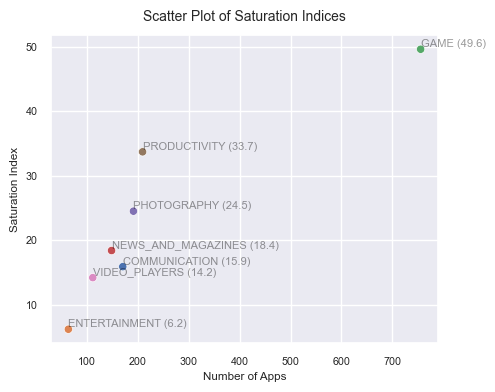

In [28]:
# Scatter plot of top 5 MP ranks
sns.set(font_scale=0.7)
fig, axs = plt.subplots(figsize=[5,4])
sns.scatterplot(x='NumOfApp', y='Sat', hue='Category', legend=False, data=table1)

axs.set(xlabel='Number of Apps', ylabel='Saturation Index')
plt.title('Scatter Plot of Saturation Indices', fontsize=10, y=1.02)

# Annotate select points in scatterplot
for i, row in table1.iterrows():  
    axs.text(row['NumOfApp'], row["Sat"], row["Sat_text"], 
            fontsize=8, ha='left', va='bottom', color='black', alpha=0.4)
plt.show()

The scatter plot clearly shows the **Entertainment** category as the least saturated (6.2), and thus the best option for introducing a new app with a high chance of popularity and user engagement.

## Final Proposed App Profile

#### Summary of data analysis:

The summarized results of the data analysis are presented in the table below: 

<div style="display: inline-block">

|Category|Number of Apps|Popularity Index|Saturation Index|Comments|
|:----|:----|:----|:-----|:----|
|GAME|756|16.7|49.6|Very high popularity index, but also extremely saturated and highly competitive; very low visibility for new app entrants. Not recommended.|
|COMMUNICATION|170|11.0|15.9|High popularity index with median saturation, but dominated by a few very sucessful and well established app. Recommended with some reservation.|
|**ENTERTAINMENT**|**63**|**10.2**|**6.2**|**Median popularity index, but very low saturation. Best category for new app entrants; highly recommend.**|
|PHOTOGRAPHY|191|8.1|24.5|Low popularity index; high saturation. Not recommended at all.|
|VIDEO PLAYERS|111|8.1|14.2|Low popularity index with median saturation. Not suitable based on low popularity.|
    
</div>

The best category for proposing an app profile is determined to be the **ENTERTAINMENT** category.

#### Fine-tuning the results

We can further refine the results by diving deeper into the Entertainment category and looking at its constituent genres.

In [29]:
## Fine-tuning the analysis results
df=playstore[['App','Installs','Reviews','Genres']][playstore.Category=='ENTERTAINMENT'] # Extract the Entertainment subset 
df.Installs.groupby(df.Genres).mean().round() # Check the average downloads for each genre 

Genres
Entertainment                  10778246.0
Entertainment;Brain Games       5500000.0
Entertainment;Music & Video     3125000.0
Name: Installs, dtype: float64

It is evident that Entertainment apps of the basic **Entertainment** genre get the highest average downloads.

So we look closer at the individual apps within this sub-genre. We do this with the aid of a Pie chart, where the size of the pie slice represents the total downloads for the app. The aim here is to find a pattern among the apps here and hopefully apply this in our app profile.

In [30]:
## Fine-tuning the analysis results
df = df[df.Genres=='Entertainment'] # Extract the Entertainment sub-genre 
df['FilteredApp'] = df[['App','Installs']].apply(
    lambda x: x.App if x.Installs >= 5000000 else '', axis=1) # Filtered labels for the pie chart

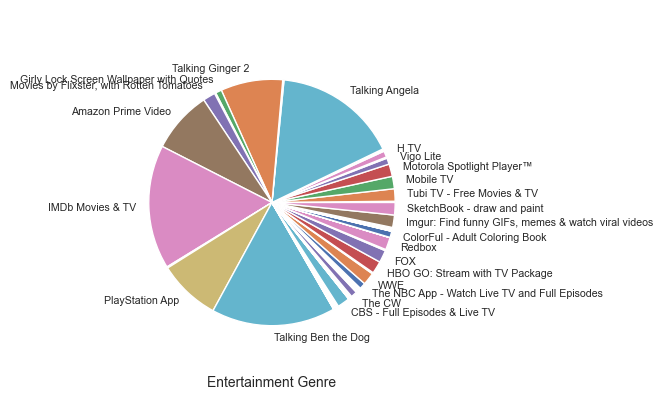

In [31]:
# Pie chart of the Entertainment sub-genre (by downloads)
sns.set(font_scale=.7)
fig, axs = plt.subplots(figsize=[5,5])
plt.pie(df.Installs, labels=df.FilteredApp, radius=.8)
plt.title('Entertainment Genre', fontsize=10, y=0)
plt.show()

It would seem that the apps here are predominantly built around **making some form of already established audio-visual entertainment available on mobile devices.** And a significant number of them provide movies or video streaming services, or links to channels that do so.

It is also evident that the largest individual downloads are (again) attributed to **Game-like apps** - "Talking Angela", "Talking Ben the dog". This is something we can take advantage of in the form. Special, free "add ons" that provide a game-like subroutine can be built in the app.

#### The Proposed App Profile:

Based on the analysis of the provided Play Store dataset, the following profile is proposed to ensure popularity and attract the most users:

- App Category: **ENTERTAINMENT**

- Sub-category: **AUDIO-VISUAL ENTERTAINMENT**, preferably built around an already established entertainment channel (streaming services rank highest).

- Poposed Add-ons: **Game-like submenus** like MOVIE QUIZES, etc.

## Acknowledgements

- This project was adapted from one of the many free and publicly available Python project ideas from [DataQuest.io](https://www.dataquest.io/blog/python-projects-for-beginners/).
  
- The project dataset was sourced from [Kaggle.com](https://www.kaggle.com/datasets/lava18/google-play-store-apps), which hosts a repository of several publicly available datasets.